# Traffic sign detection with SSD

In [63]:
import time
import numpy as np
import cv2
import csv
import glob
import random
import matplotlib as mpl
import matplotlib.pyplot as plt

import mxnet as mx
import mxnet.image as image
from mxnet import nd
from mxnet.gluon import nn
from mxnet import gluon
from mxnet.contrib.ndarray import MultiBoxTarget
from mxnet.contrib.ndarray import MultiBoxPrior
from mxnet.contrib.ndarray import MultiBoxDetection

print("all module imported")

all module imported


# Load Data

### Load Image

In [3]:
NUM_CLASS = 43
BATCH_SIZE = 4
DATA_SHAPE = 512

train_data = mx.image.ImageIter(  
   batch_size=BATCH_SIZE, label_width = 1,
   data_shape=(3, DATA_SHAPE, DATA_SHAPE),  
   path_imgrec='./dataset/dataset.rec',  
   path_imgidx='./dataset/dataset.idx',  #help shuffle performance
   shuffle=True)
test_data = mx.image.ImageIter(  
   batch_size=BATCH_SIZE, label_width = 1,
   data_shape=(3, DATA_SHAPE, DATA_SHAPE),  
   path_imgrec='./dataset/dataset.rec',  
   path_imgidx='./dataset/dataset.idx',  #help shuffle performance
   shuffle=True)

batch = train_data.next()

### Load Label

In [4]:
paths = glob.glob("dataset/scene-jpg/*.jpg")
labels = nd.zeros((len(paths), NUM_CLASS+1, 5)) -1.
print(labels.shape)
gts = open("dataset/gt1.txt",'r').read().split('\n')[:-1]
for gt in gts:
    line = gt.split(";")
    idx = int(line[0].split(".")[0])
    minx = float(line[1])
    miny = float(line[2])
    maxx = float(line[3])
    maxy = float(line[4])
    label = float(line[5])
    labels[idx][int(label)] = [label, minx, miny, maxx, maxy]
print(len(paths), len(gts), len(labels))
print(labels[1])

(900, 44, 5)
900 1213 900

[[-1.     -1.     -1.     -1.     -1.    ]
 [-1.     -1.     -1.     -1.     -1.    ]
 [-1.     -1.     -1.     -1.     -1.    ]
 [-1.     -1.     -1.     -1.     -1.    ]
 [-1.     -1.     -1.     -1.     -1.    ]
 [-1.     -1.     -1.     -1.     -1.    ]
 [-1.     -1.     -1.     -1.     -1.    ]
 [-1.     -1.     -1.     -1.     -1.    ]
 [-1.     -1.     -1.     -1.     -1.    ]
 [-1.     -1.     -1.     -1.     -1.    ]
 [-1.     -1.     -1.     -1.     -1.    ]
 [-1.     -1.     -1.     -1.     -1.    ]
 [-1.     -1.     -1.     -1.     -1.    ]
 [13.      0.7154  0.4188  0.7581  0.4875]
 [-1.     -1.     -1.     -1.     -1.    ]
 [-1.     -1.     -1.     -1.     -1.    ]
 [-1.     -1.     -1.     -1.     -1.    ]
 [-1.     -1.     -1.     -1.     -1.    ]
 [-1.     -1.     -1.     -1.     -1.    ]
 [-1.     -1.     -1.     -1.     -1.    ]
 [-1.     -1.     -1.     -1.     -1.    ]
 [-1.     -1.     -1.     -1.     -1.    ]
 [-1.     -1.     -1.     -

### Load sign names

In [65]:
signname_file = "dataset/signnames.csv"
with open(signname_file) as f:
    f.readline() # skip the headers
    signnames = [row[1] for row in csv.reader(f)]
print(signnames)

['Speed limit (20km/h)', 'Speed limit (30km/h)', 'Speed limit (50km/h)', 'Speed limit (60km/h)', 'Speed limit (70km/h)', 'Speed limit (80km/h)', 'End of speed limit (80km/h)', 'Speed limit (100km/h)', 'Speed limit (120km/h)', 'No passing', 'No passing for vehicles over 3.5 metric tons', 'Right-of-way at the next intersection', 'Priority road', 'Yield', 'Stop', 'No vehicles', 'Vehicles over 3.5 metric tons prohibited', 'No entry', 'General caution', 'Dangerous curve to the left', 'Dangerous curve to the right', 'Double curve', 'Bumpy road', 'Slippery road', 'Road narrows on the right', 'Road work', 'Traffic signals', 'Pedestrians', 'Children crossing', 'Bicycles crossing', 'Beware of ice/snow', 'Wild animals crossing', 'End of all speed and passing limits', 'Turn right ahead', 'Turn left ahead', 'Ahead only', 'Go straight or right', 'Go straight or left', 'Keep right', 'Keep left', 'Roundabout mandatory', 'End of no passing', 'End of no passing by vehicles over 3.5 metric tons']


### Show example

In [100]:
%matplotlib inline
batch_label = batch.label[0].asnumpy().astype(int)
print(batch_label)
img = batch.data[0][0]
img = img.transpose((1, 2, 0))
img = img.clip(0,255).asnumpy()/255
mul_label = labels[batch_label][0].asnumpy()
print(mul_label.shape)

[571 377 528 790]
(44, 5)


17


IndexError: tuple index out of range

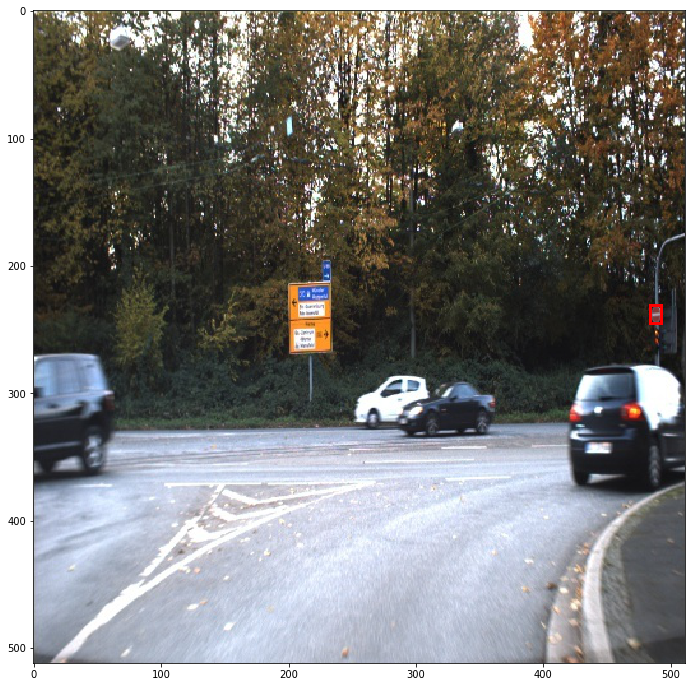

In [112]:
fig,ax = plt.subplots(1,  figsize=(12,12))
ax.imshow(img)
for box in mul_label:
    sign = int(box[0])
    if(sign < 0):
        continue
    print(sign)
    minx = int(box[1] * DATA_SHAPE)
    miny = int(box[2] * DATA_SHAPE)
    maxx = int(box[3] * DATA_SHAPE)
    maxy = int(box[4] * DATA_SHAPE)
    rect = plt.Rectangle((minx, miny), maxx-minx, maxy-miny,fill=False, edgecolor='red', linewidth=3)
    ax.add_patch(rect)
    ax.text(minx, miny-2, '{:s} {:.3f}'.format(signnames[sign]),fontsize=12, color='white')
plt.show()

# SSD Detector

In [7]:
n = 40
# shape: batch x channel x height x weight
x = nd.random_uniform(shape=(1, 3, n, n))  

y = MultiBoxPrior(x, sizes=[.5, .25, .1], ratios=[1, 2, .5])

# the first anchor box generated for pixel at (20,20)
# its format is (x_min, y_min, x_max, y_max)
boxes = y.reshape((n, n, -1, 4))
print('The first anchor box at row 21, column 21:', boxes[20, 20, :, :])

The first anchor box at row 21, column 21: 
[[0.2625     0.2625     0.7625     0.7625    ]
 [0.3875     0.3875     0.6375     0.6375    ]
 [0.46249998 0.46249998 0.5625     0.5625    ]
 [0.1589466  0.33572328 0.86605334 0.6892767 ]
 [0.33572328 0.1589466  0.6892767  0.86605334]]
<NDArray 5x4 @cpu(0)>


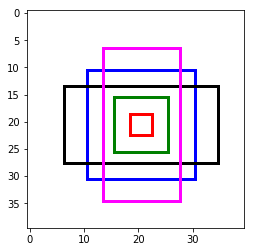

In [8]:
def box_to_rect(box, color, linewidth=3):
    """convert an anchor box to a matplotlib rectangle"""
    box = box.asnumpy()
    return plt.Rectangle(
        (box[0], box[1]), (box[2]-box[0]), (box[3]-box[1]), 
        fill=False, edgecolor=color, linewidth=linewidth)
colors = ['blue', 'green', 'red', 'black', 'magenta']
plt.imshow(nd.ones((n, n, 3)).asnumpy())
anchors = boxes[20, 20, :, :]
for i in range(anchors.shape[0]):
    plt.gca().add_patch(box_to_rect(anchors[i,:]*n, colors[i]))
plt.show()

In [9]:
def class_predictor(num_anchors, num_classes):
    """return a layer to predict classes"""
    return nn.Conv2D(num_anchors * (num_classes + 1), 3, padding=1)

cls_pred = class_predictor(5, NUM_CLASS)
cls_pred.initialize()
x = nd.zeros((BATCH_SIZE, 3, 512, 512))
print('Class prediction', cls_pred(x).shape)

Class prediction (4, 220, 512, 512)


In [10]:
def box_predictor(num_anchors):
    """return a layer to predict delta locations"""
    return nn.Conv2D(num_anchors * 4, 3, padding=1)

box_pred = box_predictor(10)
box_pred.initialize()
x = nd.zeros((BATCH_SIZE, 3, 512, 412))
print('Box prediction', box_pred(x).shape)

Box prediction (4, 40, 512, 412)


In [11]:
def down_sample(num_filters):
    """stack two Conv-BatchNorm-Relu blocks and then a pooling layer 
    to halve the feature size"""
    out = nn.HybridSequential()
    for _ in range(2):
        out.add(nn.Conv2D(num_filters, 3, strides=1, padding=1))
        out.add(nn.BatchNorm(in_channels=num_filters))
        out.add(nn.Activation('relu'))
    out.add(nn.MaxPool2D(2))
    return out

blk = down_sample(10)
blk.initialize()
x = nd.zeros((BATCH_SIZE, 3, 512, 512))
print('Before', x.shape, 'after', blk(x).shape)

Before (4, 3, 512, 512) after (4, 10, 256, 256)


In [12]:
feat1 = nd.zeros((BATCH_SIZE, 8, 512, 512))
print('Feature map 1', feat1.shape)
cls_pred1 = class_predictor(5, NUM_CLASS)
cls_pred1.initialize()
y1 = cls_pred1(feat1)
print('Class prediction for feature map 1', y1.shape)
# down-sample 
ds = down_sample(16)
ds.initialize()
feat2 = ds(feat1)
print('Feature map 2', feat2.shape)
cls_pred2 = class_predictor(3, NUM_CLASS)
cls_pred2.initialize()
y2 = cls_pred2(feat2)
print('Class prediction for feature map 2', y2.shape)

Feature map 1 (4, 8, 512, 512)
Class prediction for feature map 1 (4, 220, 512, 512)
Feature map 2 (4, 16, 256, 256)
Class prediction for feature map 2 (4, 132, 256, 256)


In [13]:
def flatten_prediction(pred):
    return nd.flatten(nd.transpose(pred, axes=(0, 2, 3, 1)))

def concat_predictions(preds):
    return nd.concat(*preds, dim=1)

flat_y1 = flatten_prediction(y1)
print('Flatten class prediction 1', flat_y1.shape)
flat_y2 = flatten_prediction(y2)
print('Flatten class prediction 2', flat_y2.shape)
print('Concat class predictions', concat_predictions([flat_y1, flat_y2]).shape)

Flatten class prediction 1 (4, 57671680)
Flatten class prediction 2 (4, 8650752)
Concat class predictions (4, 66322432)


In [14]:
def body():
    """return the body network"""
    out = nn.HybridSequential()
    for nfilters in [16, 32, 64]:
        out.add(down_sample(nfilters))
    return out

bnet = body()
bnet.initialize()
x = nd.zeros((16, 3, 512, 512))
print('Body network', [y.shape for y in bnet(x)])

Body network [(64, 64, 64), (64, 64, 64), (64, 64, 64), (64, 64, 64), (64, 64, 64), (64, 64, 64), (64, 64, 64), (64, 64, 64), (64, 64, 64), (64, 64, 64), (64, 64, 64), (64, 64, 64), (64, 64, 64), (64, 64, 64), (64, 64, 64), (64, 64, 64)]


In [15]:
def toy_ssd_model(num_anchors, num_classes):
    """return SSD modules"""
    downsamples = nn.Sequential()
    class_preds = nn.Sequential()
    box_preds = nn.Sequential()

    downsamples.add(down_sample(128))
    downsamples.add(down_sample(128))
    downsamples.add(down_sample(128))
    
    for scale in range(5):
        class_preds.add(class_predictor(num_anchors, num_classes))
        box_preds.add(box_predictor(num_anchors))
    
    return body(), downsamples, class_preds, box_preds

print(toy_ssd_model(5, NUM_CLASS))

(HybridSequential(
  (0): HybridSequential(
    (0): Conv2D(None -> 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm(use_global_stats=False, eps=1e-05, axis=1, momentum=0.9, fix_gamma=False, in_channels=16)
    (2): Activation(relu)
    (3): Conv2D(None -> 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm(use_global_stats=False, eps=1e-05, axis=1, momentum=0.9, fix_gamma=False, in_channels=16)
    (5): Activation(relu)
    (6): MaxPool2D(size=(2, 2), stride=(2, 2), padding=(0, 0), ceil_mode=False)
  )
  (1): HybridSequential(
    (0): Conv2D(None -> 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm(use_global_stats=False, eps=1e-05, axis=1, momentum=0.9, fix_gamma=False, in_channels=32)
    (2): Activation(relu)
    (3): Conv2D(None -> 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm(use_global_stats=False, eps=1e-05, axis=1, momentum=0.9, fix_gamma=False, in_channels=32)
    (5): Activati

In [16]:
def toy_ssd_forward(x, body, downsamples, class_preds, box_preds, sizes, ratios):                
    # extract feature with the body network        
    x = body(x)
        
    # for each scale, add anchors, box and class predictions,
    # then compute the input to next scale 
    default_anchors = []
    predicted_boxes = []  
    predicted_classes = []
                        
    for i in range(5):
        default_anchors.append(MultiBoxPrior(x, sizes=sizes[i], ratios=ratios[i]))
        predicted_boxes.append(flatten_prediction(box_preds[i](x)))
        predicted_classes.append(flatten_prediction(class_preds[i](x)))
        if i < 3:
            x = downsamples[i](x)
        elif i == 3:
            # simply use the pooling layer
            x = nd.Pooling(x, global_pool=True, pool_type='max', kernel=(4, 4))

    return default_anchors, predicted_classes, predicted_boxes

In [17]:
class ToySSD(gluon.Block):
    def __init__(self, num_classes, **kwargs):
        super(ToySSD, self).__init__(**kwargs)
        # anchor box sizes for 4 feature scales
        self.anchor_sizes = [[.2, .272], [.37, .447], [.54, .619], [.71, .79], [.88, .961]]
        # anchor box ratios for 4 feature scales
        self.anchor_ratios = [[1, 2, .5]] * 5
        self.num_classes = num_classes

        with self.name_scope():
            self.body, self.downsamples, self.class_preds, self.box_preds = toy_ssd_model(4, num_classes)
            
    def forward(self, x):
        default_anchors, predicted_classes, predicted_boxes = toy_ssd_forward(x, self.body, self.downsamples,
            self.class_preds, self.box_preds, self.anchor_sizes, self.anchor_ratios)
        # we want to concatenate anchors, class predictions, box predictions from different layers
        anchors = concat_predictions(default_anchors)
        box_preds = concat_predictions(predicted_boxes)
        class_preds = concat_predictions(predicted_classes)
        # it is better to have class predictions reshaped for softmax computation
        class_preds = nd.reshape(class_preds, shape=(0, -1, self.num_classes + 1))
        
        return anchors, class_preds, box_preds

In [18]:
# instantiate a ToySSD network with 10 classes
net = ToySSD(NUM_CLASS)
net.initialize()
x = nd.zeros((BATCH_SIZE, 3, DATA_SHAPE, DATA_SHAPE))
default_anchors, class_predictions, box_predictions = net(x)
print('Outputs:', 'anchors', default_anchors.shape, 'class prediction', class_predictions.shape, 'box prediction', box_predictions.shape)

Outputs: anchors (1, 21764, 4) class prediction (4, 21764, 44) box prediction (4, 87056)


# Train

In [19]:
def training_targets(default_anchors, class_predicts, labels):
    class_predicts = nd.transpose(class_predicts, axes=(0, 2, 1))
    z = MultiBoxTarget(*[default_anchors, labels, class_predicts])
    box_target = z[0]  # box offset target for (x, y, width, height)
    box_mask = z[1]  # mask is used to ignore box offsets we don't want to penalize, e.g. negative samples
    cls_target = z[2]  # cls_target is an array of labels for all anchors boxes
    return box_target, box_mask, cls_target

In [20]:
class FocalLoss(gluon.loss.Loss):
    def __init__(self, axis=-1, alpha=0.25, gamma=2, batch_axis=0, **kwargs):
        super(FocalLoss, self).__init__(None, batch_axis, **kwargs)
        self._axis = axis
        self._alpha = alpha
        self._gamma = gamma
    
    def hybrid_forward(self, F, output, label):
        output = F.softmax(output)
        pt = F.pick(output, label, axis=self._axis, keepdims=True)
        loss = -self._alpha * ((1 - pt) ** self._gamma) * F.log(pt)
        return F.mean(loss, axis=self._batch_axis, exclude=True)

# cls_loss = gluon.loss.SoftmaxCrossEntropyLoss()
cls_loss = FocalLoss()
print(cls_loss)

FocalLoss(batch_axis=0, w=None)


In [21]:
class SmoothL1Loss(gluon.loss.Loss):
    def __init__(self, batch_axis=0, **kwargs):
        super(SmoothL1Loss, self).__init__(None, batch_axis, **kwargs)
    
    def hybrid_forward(self, F, output, label, mask):
        loss = F.smooth_l1((output - label) * mask, scalar=1.0)
        return F.mean(loss, self._batch_axis, exclude=True)

box_loss = SmoothL1Loss()
print(box_loss)

SmoothL1Loss(batch_axis=0, w=None)


In [22]:
cls_metric = mx.metric.Accuracy()
box_metric = mx.metric.MAE()

In [23]:
### Set context for training
ctx = mx.gpu()  # it may takes too long to train using CPU
_ = nd.zeros(1, ctx=ctx)
# pad label for cuda implementation
# train_data.reshape(label_shape=(NUM_CLASS + 1, 5))
# train_data = test_data.sync_label_shape(train_data)
print(labels)
# labels = nd.array(labels)


[[[-1.     -1.     -1.     -1.     -1.    ]
  [-1.     -1.     -1.     -1.     -1.    ]
  [-1.     -1.     -1.     -1.     -1.    ]
  ...
  [-1.     -1.     -1.     -1.     -1.    ]
  [-1.     -1.     -1.     -1.     -1.    ]
  [-1.     -1.     -1.     -1.     -1.    ]]

 [[-1.     -1.     -1.     -1.     -1.    ]
  [-1.     -1.     -1.     -1.     -1.    ]
  [-1.     -1.     -1.     -1.     -1.    ]
  ...
  [-1.     -1.     -1.     -1.     -1.    ]
  [-1.     -1.     -1.     -1.     -1.    ]
  [-1.     -1.     -1.     -1.     -1.    ]]

 [[-1.     -1.     -1.     -1.     -1.    ]
  [-1.     -1.     -1.     -1.     -1.    ]
  [-1.     -1.     -1.     -1.     -1.    ]
  ...
  [-1.     -1.     -1.     -1.     -1.    ]
  [-1.     -1.     -1.     -1.     -1.    ]
  [-1.     -1.     -1.     -1.     -1.    ]]

 ...

 [[-1.     -1.     -1.     -1.     -1.    ]
  [-1.     -1.     -1.     -1.     -1.    ]
  [-1.     -1.     -1.     -1.     -1.    ]
  ...
  [-1.     -1.     -1.     -1.     -1. 

In [24]:
net = ToySSD(NUM_CLASS)
net.initialize(mx.init.Xavier(magnitude=2), ctx=ctx)
net.collect_params().reset_ctx(ctx)
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.1, 'wd': 5e-4})

In [25]:
log_interval = 20
start_epoch = 0
epochs = 50

In [27]:
from mxnet import autograd as ag
for epoch in range(start_epoch, epochs):
    # reset iterator and tick
    train_data.reset()
    cls_metric.reset()
    box_metric.reset()
    tic = time.time()
    # iterate through all batch
    for i, batch in enumerate(train_data):
        btic = time.time()
        # record gradients
        with ag.record():
            x = batch.data[0].as_in_context(ctx)
            batch_label = batch.label[0].asnumpy().astype(int)
            y = labels[batch_label].as_in_context(ctx)
#             print(x.shape, y.shape)
            default_anchors, class_predictions, box_predictions = net(x)
            box_target, box_mask, cls_target = training_targets(default_anchors, class_predictions, y)
            # losses
            loss1 = cls_loss(class_predictions, cls_target)
            loss2 = box_loss(box_predictions, box_target, box_mask)
            # sum all losses
            loss = loss1 + loss2
            # backpropagate
            loss.backward()
        # apply 
        trainer.step(BATCH_SIZE)
        # update metrics
        cls_metric.update([cls_target], [nd.transpose(class_predictions, (0, 2, 1))])
        box_metric.update([box_target], [box_predictions * box_mask])
        if (i + 1) % log_interval == 0:
            name1, val1 = cls_metric.get()
            name2, val2 = box_metric.get()
            print('[Epoch %d Batch %d] speed: %f samples/s, training: %s=%f, %s=%f' 
                  %(epoch ,i, BATCH_SIZE/(time.time()-btic), name1, val1, name2, val2))
    
    # end of epoch logging
    name1, val1 = cls_metric.get()
    name2, val2 = box_metric.get()
    print('[Epoch %d] training: %s=%f, %s=%f'%(epoch, name1, val1, name2, val2))
    print('[Epoch %d] time cost: %f'%(epoch, time.time()-tic))
    
# we can save the trained parameters to disk
net.save_params('ssd_%d.params' % epochs)

[Epoch 0 Batch 19] speed: 10.530032 samples/s, training: accuracy=0.994514, mae=0.000272
[Epoch 0 Batch 39] speed: 10.055655 samples/s, training: accuracy=0.996440, mae=0.000280
[Epoch 0 Batch 59] speed: 10.430342 samples/s, training: accuracy=0.997464, mae=0.000290
[Epoch 0 Batch 79] speed: 11.097804 samples/s, training: accuracy=0.998028, mae=0.000279
[Epoch 0 Batch 99] speed: 10.210864 samples/s, training: accuracy=0.998373, mae=0.000286
[Epoch 0 Batch 119] speed: 10.458646 samples/s, training: accuracy=0.998605, mae=0.000284
[Epoch 0 Batch 139] speed: 10.403520 samples/s, training: accuracy=0.998771, mae=0.000284
[Epoch 0 Batch 159] speed: 10.714795 samples/s, training: accuracy=0.998895, mae=0.000284
[Epoch 0 Batch 179] speed: 10.489582 samples/s, training: accuracy=0.998992, mae=0.000283
[Epoch 0 Batch 199] speed: 10.376791 samples/s, training: accuracy=0.999070, mae=0.000281
[Epoch 0 Batch 219] speed: 10.517806 samples/s, training: accuracy=0.999132, mae=0.000283
[Epoch 0] train

[Epoch 7 Batch 199] speed: 10.581676 samples/s, training: accuracy=0.999927, mae=0.000265
[Epoch 7 Batch 219] speed: 10.473905 samples/s, training: accuracy=0.999928, mae=0.000268
[Epoch 7] training: accuracy=0.999928, mae=0.000270
[Epoch 7] time cost: 95.836831
[Epoch 8 Batch 19] speed: 10.790664 samples/s, training: accuracy=0.999940, mae=0.000301
[Epoch 8 Batch 39] speed: 10.292259 samples/s, training: accuracy=0.999943, mae=0.000282
[Epoch 8 Batch 59] speed: 10.559777 samples/s, training: accuracy=0.999946, mae=0.000267
[Epoch 8 Batch 79] speed: 10.552777 samples/s, training: accuracy=0.999947, mae=0.000264
[Epoch 8 Batch 99] speed: 10.487536 samples/s, training: accuracy=0.999947, mae=0.000266
[Epoch 8 Batch 119] speed: 10.365514 samples/s, training: accuracy=0.999947, mae=0.000271
[Epoch 8 Batch 139] speed: 10.113196 samples/s, training: accuracy=0.999948, mae=0.000267
[Epoch 8 Batch 159] speed: 10.845730 samples/s, training: accuracy=0.999948, mae=0.000271
[Epoch 8 Batch 179] sp

[Epoch 15 Batch 119] speed: 11.480393 samples/s, training: accuracy=0.999949, mae=0.000271
[Epoch 15 Batch 139] speed: 11.208910 samples/s, training: accuracy=0.999949, mae=0.000267
[Epoch 15 Batch 159] speed: 11.587371 samples/s, training: accuracy=0.999950, mae=0.000261
[Epoch 15 Batch 179] speed: 11.211007 samples/s, training: accuracy=0.999949, mae=0.000262
[Epoch 15 Batch 199] speed: 11.050961 samples/s, training: accuracy=0.999950, mae=0.000259
[Epoch 15 Batch 219] speed: 11.762573 samples/s, training: accuracy=0.999949, mae=0.000261
[Epoch 15] training: accuracy=0.999949, mae=0.000261
[Epoch 15] time cost: 90.910300
[Epoch 16 Batch 19] speed: 11.217986 samples/s, training: accuracy=0.999944, mae=0.000280
[Epoch 16 Batch 39] speed: 11.319268 samples/s, training: accuracy=0.999947, mae=0.000269
[Epoch 16 Batch 59] speed: 11.196470 samples/s, training: accuracy=0.999948, mae=0.000260
[Epoch 16 Batch 79] speed: 11.138844 samples/s, training: accuracy=0.999950, mae=0.000254
[Epoch 16

[Epoch 23 Batch 19] speed: 10.972292 samples/s, training: accuracy=0.999950, mae=0.000260
[Epoch 23 Batch 39] speed: 11.135754 samples/s, training: accuracy=0.999950, mae=0.000260
[Epoch 23 Batch 59] speed: 11.179005 samples/s, training: accuracy=0.999950, mae=0.000251
[Epoch 23 Batch 79] speed: 11.153722 samples/s, training: accuracy=0.999951, mae=0.000247
[Epoch 23 Batch 99] speed: 11.173317 samples/s, training: accuracy=0.999949, mae=0.000258
[Epoch 23 Batch 119] speed: 11.195663 samples/s, training: accuracy=0.999949, mae=0.000256
[Epoch 23 Batch 139] speed: 10.920974 samples/s, training: accuracy=0.999948, mae=0.000261
[Epoch 23 Batch 159] speed: 11.176436 samples/s, training: accuracy=0.999948, mae=0.000261
[Epoch 23 Batch 179] speed: 11.885964 samples/s, training: accuracy=0.999949, mae=0.000260
[Epoch 23 Batch 199] speed: 11.024043 samples/s, training: accuracy=0.999949, mae=0.000257
[Epoch 23 Batch 219] speed: 11.203266 samples/s, training: accuracy=0.999950, mae=0.000253
[Epo

[Epoch 30 Batch 159] speed: 10.383791 samples/s, training: accuracy=0.999949, mae=0.000251
[Epoch 30 Batch 179] speed: 10.686254 samples/s, training: accuracy=0.999949, mae=0.000249
[Epoch 30 Batch 199] speed: 10.677338 samples/s, training: accuracy=0.999950, mae=0.000248
[Epoch 30 Batch 219] speed: 10.827999 samples/s, training: accuracy=0.999949, mae=0.000251
[Epoch 30] training: accuracy=0.999949, mae=0.000251
[Epoch 30] time cost: 95.013978
[Epoch 31 Batch 19] speed: 10.516534 samples/s, training: accuracy=0.999950, mae=0.000252
[Epoch 31 Batch 39] speed: 10.550660 samples/s, training: accuracy=0.999951, mae=0.000246
[Epoch 31 Batch 59] speed: 10.670982 samples/s, training: accuracy=0.999951, mae=0.000240
[Epoch 31 Batch 79] speed: 10.614346 samples/s, training: accuracy=0.999952, mae=0.000238
[Epoch 31 Batch 99] speed: 10.809769 samples/s, training: accuracy=0.999950, mae=0.000245
[Epoch 31 Batch 119] speed: 10.443295 samples/s, training: accuracy=0.999950, mae=0.000245
[Epoch 31 

[Epoch 38 Batch 59] speed: 10.970556 samples/s, training: accuracy=0.999949, mae=0.000253
[Epoch 38 Batch 79] speed: 10.647394 samples/s, training: accuracy=0.999948, mae=0.000255
[Epoch 38 Batch 99] speed: 10.623083 samples/s, training: accuracy=0.999950, mae=0.000244
[Epoch 38 Batch 119] speed: 10.403649 samples/s, training: accuracy=0.999949, mae=0.000248
[Epoch 38 Batch 139] speed: 10.558674 samples/s, training: accuracy=0.999950, mae=0.000244
[Epoch 38 Batch 159] speed: 10.828342 samples/s, training: accuracy=0.999949, mae=0.000249
[Epoch 38 Batch 179] speed: 10.419440 samples/s, training: accuracy=0.999949, mae=0.000249
[Epoch 38 Batch 199] speed: 10.538988 samples/s, training: accuracy=0.999950, mae=0.000246
[Epoch 38 Batch 219] speed: 10.675646 samples/s, training: accuracy=0.999949, mae=0.000247
[Epoch 38] training: accuracy=0.999949, mae=0.000248
[Epoch 38] time cost: 95.169519
[Epoch 39 Batch 19] speed: 11.086906 samples/s, training: accuracy=0.999953, mae=0.000227
[Epoch 39

[Epoch 45 Batch 199] speed: 10.465268 samples/s, training: accuracy=0.999950, mae=0.000245
[Epoch 45 Batch 219] speed: 10.628790 samples/s, training: accuracy=0.999950, mae=0.000246
[Epoch 45] training: accuracy=0.999949, mae=0.000247
[Epoch 45] time cost: 95.043416
[Epoch 46 Batch 19] speed: 10.547807 samples/s, training: accuracy=0.999951, mae=0.000231
[Epoch 46 Batch 39] speed: 10.685710 samples/s, training: accuracy=0.999951, mae=0.000239
[Epoch 46 Batch 59] speed: 10.764244 samples/s, training: accuracy=0.999951, mae=0.000239
[Epoch 46 Batch 79] speed: 10.468657 samples/s, training: accuracy=0.999949, mae=0.000248
[Epoch 46 Batch 99] speed: 10.659117 samples/s, training: accuracy=0.999951, mae=0.000235
[Epoch 46 Batch 119] speed: 10.538174 samples/s, training: accuracy=0.999950, mae=0.000244
[Epoch 46 Batch 139] speed: 10.978294 samples/s, training: accuracy=0.999950, mae=0.000246
[Epoch 46 Batch 159] speed: 10.871945 samples/s, training: accuracy=0.999950, mae=0.000245
[Epoch 46 

(512, 512, 3)
(1, 3, 512, 512) 
[[[[255. 255. 255. ... 250. 255. 255.]
   [255. 255. 255. ... 252. 252. 255.]
   [255. 255. 255. ... 252. 255. 255.]
   ...
   [255.  20.  20. ...  23.  23. 255.]
   [255.  21.  20. ...  24.  24. 255.]
   [255.  21.  20. ...  24.  23. 255.]]

  [[255. 255. 255. ... 254. 255. 254.]
   [255. 255. 255. ... 255. 251. 253.]
   [255. 255. 255. ... 254. 255. 255.]
   ...
   [255.  20.  20. ...  23.  23. 255.]
   [255.  21.  20. ...  24.  24. 255.]
   [255.  21.  20. ...  24.  23. 255.]]

  [[255. 255. 255. ... 253. 251. 248.]
   [255. 255. 255. ... 255. 247. 246.]
   [255. 255. 255. ... 249. 251. 250.]
   ...
   [255.  20.  20. ...  23.  23. 255.]
   [255.  21.  20. ...  24.  24. 255.]
   [255.  21.  20. ...  24.  23. 255.]]]]
<NDArray 1x3x512x512 @cpu(0)>


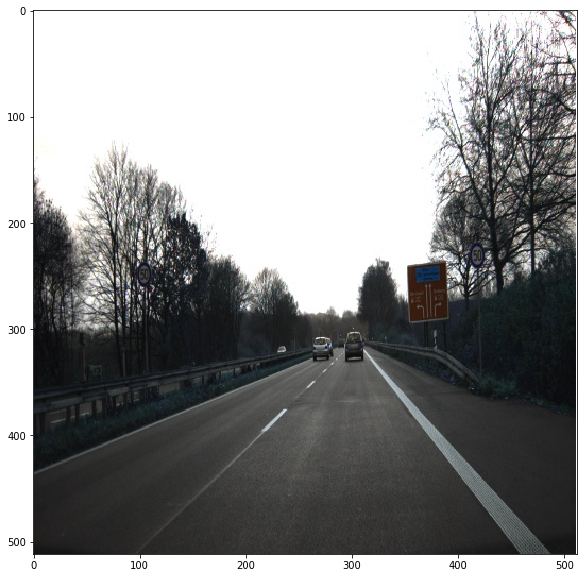

In [88]:
def preprocess(image):
    """Takes an image and apply preprocess"""
    # swap BGR to RGB
    image = image[:, :, (2, 1, 0)]
    # convert to float before subtracting mean
    image = image.astype(np.float32)
    # subtract mean
#     image -= np.array([123, 117, 104])
    # organize as [batch-channel-height-width]
    image = np.transpose(image, (2, 0, 1))
    image = image[np.newaxis, :]
    # convert to ndarray
    image = nd.array(image)
    return image

index = random.randint(0, len(labels))
image = cv2.imread('dataset/scene-jpg/'+ str(index).zfill(5) +'.jpg')
print(image.shape)
plt.imshow(image)
x = preprocess(image)
print(x.shape, x)

In [89]:
anchors, cls_preds, box_preds = net(x.as_in_context(ctx))
print('anchors', anchors)
print('class predictions', cls_preds)
print('box delta predictions', box_preds)

anchors 
[[[-0.0921875  -0.0921875   0.1078125   0.1078125 ]
  [-0.1281875  -0.1281875   0.1438125   0.1438125 ]
  [-0.13360886 -0.06289818  0.14923386  0.07852318]
  ...
  [ 0.01949999  0.01949999  0.9805      0.9805    ]
  [-0.12225395  0.18887302  1.1222539   0.81112695]
  [ 0.18887302 -0.12225395  0.81112695  1.1222539 ]]]
<NDArray 1x21764x4 @gpu(0)>
class predictions 
[[[ 5.93720484e+00 -2.48669773e-01  5.52966297e-02 ... -1.33635730e-01
   -6.51089996e-02 -8.44829455e-02]
  [ 5.86567354e+00  1.69435155e-03 -2.46629253e-01 ... -3.96158636e-01
   -2.50494331e-01 -3.78387690e-01]
  [ 5.58620262e+00 -1.34664699e-01 -1.57740608e-01 ... -2.65774578e-01
   -1.05651900e-01 -1.24444336e-01]
  ...
  [ 3.09622455e+00  9.88152772e-02 -8.03377703e-02 ... -2.18250617e-01
   -4.59849089e-01 -3.89657408e-01]
  [ 3.21877480e+00 -2.48184308e-01 -1.26391379e-02 ... -1.17997020e-01
    2.36736685e-01  1.46404609e-01]
  [ 3.25325823e+00 -4.41866010e-01 -6.68185502e-02 ... -2.75334567e-01
   -1.745705

In [90]:
# convert predictions to probabilities using softmax
cls_probs = nd.SoftmaxActivation(nd.transpose(cls_preds, (0, 2, 1)), mode='channel')
# apply shifts to anchors boxes, non-maximum-suppression, etc...
output = MultiBoxDetection(*[cls_probs, box_preds, anchors], force_suppress=True, clip=False)
print(output)


[[[ 1.2000000e+01  2.3684833e-02 -1.0054511e-01  1.4953265e-01
    1.1444967e+00  7.6860034e-01]
  [ 2.4000000e+01  2.3530273e-02  1.6489062e-01 -8.5191846e-02
    8.1034243e-01  1.1136698e+00]
  [-1.0000000e+00  2.2776090e-02 -2.6089847e-02  7.6175809e-02
    9.2299449e-01  8.8502854e-01]
  ...
  [-1.0000000e+00 -1.0000000e+00 -1.0000000e+00 -1.0000000e+00
   -1.0000000e+00 -1.0000000e+00]
  [-1.0000000e+00 -1.0000000e+00 -1.0000000e+00 -1.0000000e+00
   -1.0000000e+00 -1.0000000e+00]
  [-1.0000000e+00 -1.0000000e+00 -1.0000000e+00 -1.0000000e+00
   -1.0000000e+00 -1.0000000e+00]]]
<NDArray 1x21764x6 @gpu(0)>


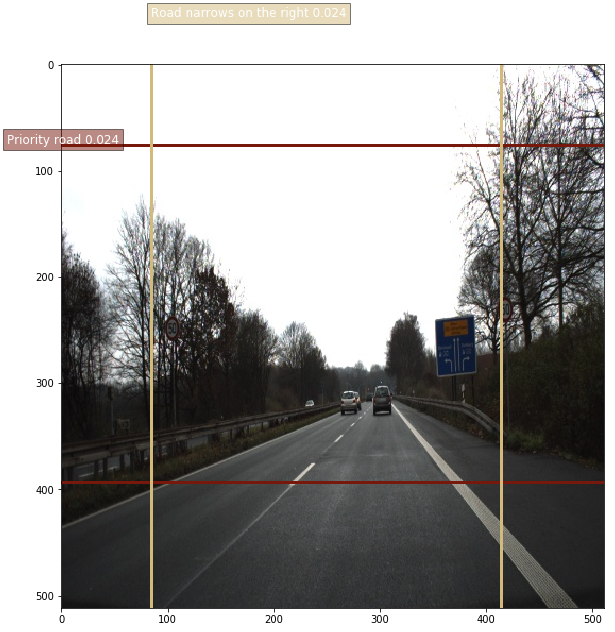

In [91]:
def display(img, out, thresh=0.5):
    mpl.rcParams['figure.figsize'] = (10,10)
    pens = dict()
    plt.clf()
    plt.imshow(img)
    for det in out:
        cid = int(det[0])
        if cid < 0:
            continue
        score = det[1]
        if score < thresh:
            continue
        if cid not in pens:
            pens[cid] = (random.random(), random.random(), random.random())
        scales = [img.shape[1], img.shape[0]] * 2
        xmin, ymin, xmax, ymax = [int(p * s) for p, s in zip(det[2:6].tolist(), scales)]
        rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, 
                             edgecolor=pens[cid], linewidth=3)
        plt.gca().add_patch(rect)
        text = signnames[cid]
        plt.gca().text(xmin, ymin-2, '{:s} {:.3f}'.format(text, score),
                       bbox=dict(facecolor=pens[cid], alpha=0.5),
                       fontsize=12, color='white')
    plt.show()
    
display(image[:, :, (2, 1, 0)], output[0].asnumpy(), thresh=0.02)